In [9]:
#Importing Libraries
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
from torch import nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch.nn import functional as F
from matplotlib import pyplot as plt
import random

In [10]:
#Selecting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
torch.cuda.empty_cache()

In [13]:
class SparseAutoencoder(nn.Module):
    def __init__(self):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )

        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.ReLU()
        )
    def forward(self, x):
        x = self.encoder(x)
        
        x = self.decoder(x)
        return x

In [14]:
model=SparseAutoencoder().to(device)

rho=0.05
beta=0.001

learning_rate=0.001
num_epochs=25
batch_size=128
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

In [15]:
train_dataset = datasets.MNIST(root='./dataset', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='./dataset', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [16]:
model_children=list(model.children())

In [17]:
def KL_divergence(rho, rho_hat):

    rho_hat = torch.mean(torch.sigmoid(rho_hat), dim=1)
    rho = torch.tensor(rho/len(rho_hat)).to(device)
    
    return torch.sum(rho * torch.log(rho/rho_hat) + (1-rho) * torch.log((1-rho)/(1-rho_hat)))

In [18]:
def sparse_loss(rho, images):
    values = images
    loss = 0
    for i in range(len(model_children)):
        values = model_children[i](values)
        loss += KL_divergence(rho, values)
    
    return loss

Epoch: 1/25  Loss: 0.1331


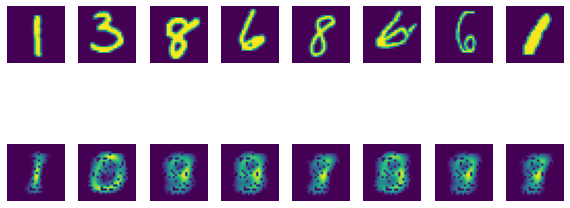

Epoch: 2/25  Loss: 0.1217


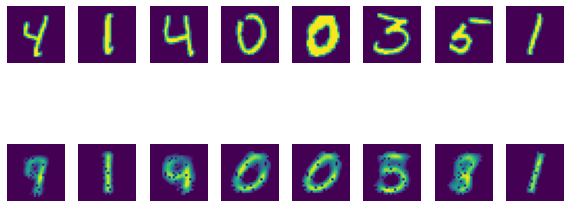

Epoch: 3/25  Loss: 0.1167


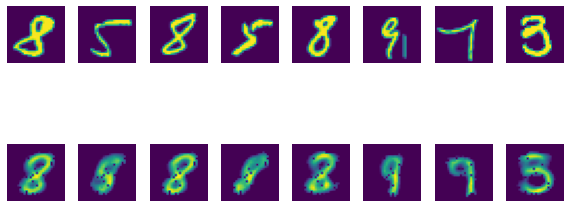

Epoch: 4/25  Loss: 0.1117


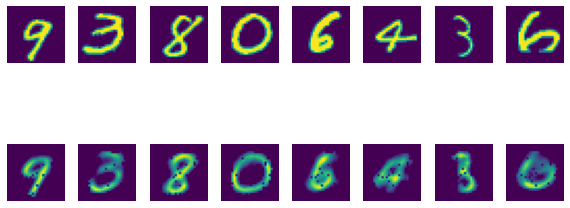

Epoch: 5/25  Loss: 0.1075


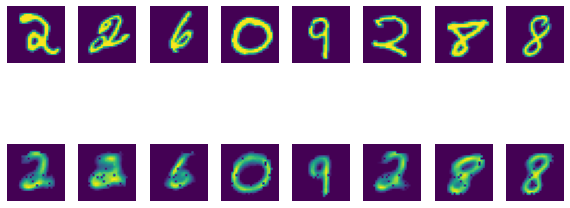

Epoch: 6/25  Loss: 0.1034


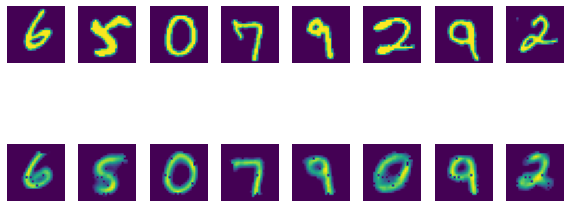

Epoch: 7/25  Loss: 0.1008


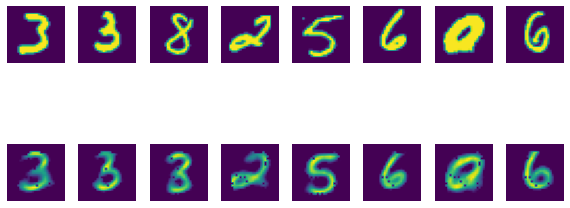

Epoch: 8/25  Loss: 0.1015


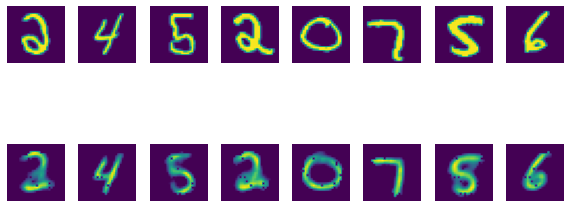

Epoch: 9/25  Loss: 0.1017


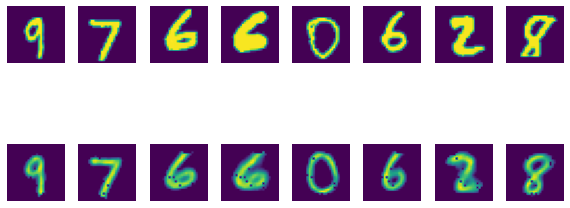

Epoch: 10/25  Loss: 0.1015


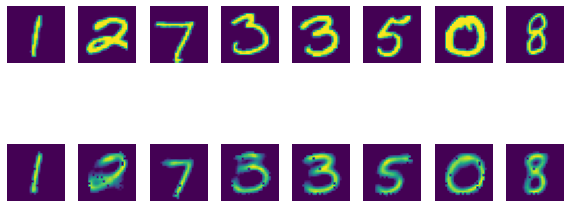

Epoch: 11/25  Loss: 0.0997


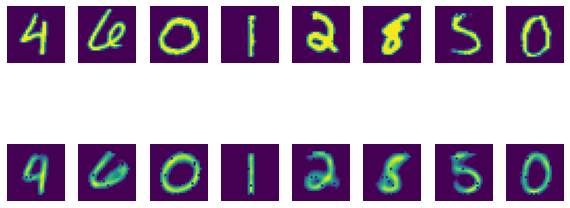

Epoch: 12/25  Loss: 0.0999


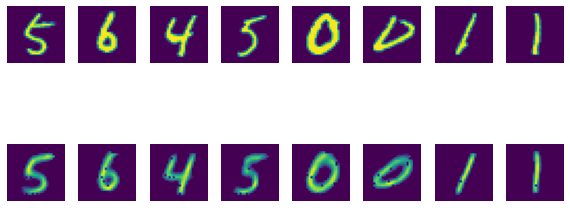

Epoch: 13/25  Loss: 0.0988


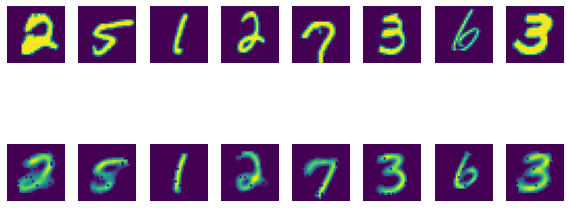

Epoch: 14/25  Loss: 0.1004


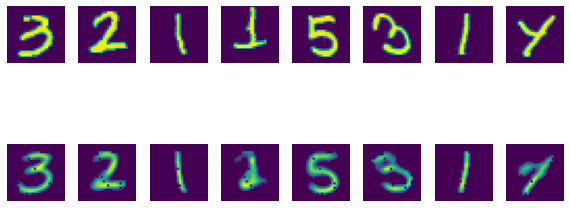

Epoch: 15/25  Loss: 0.0974


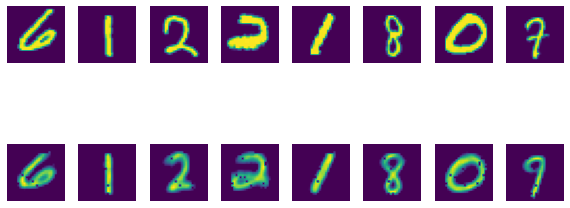

Epoch: 16/25  Loss: 0.0959


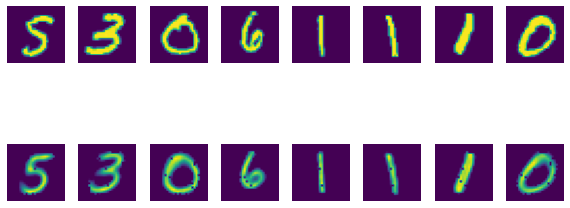

Epoch: 17/25  Loss: 0.0985


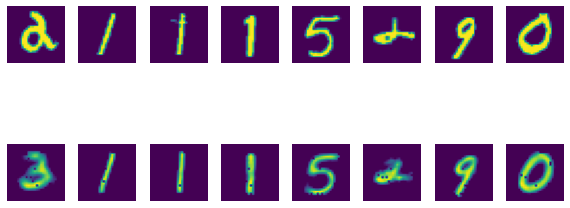

Epoch: 18/25  Loss: 0.0994


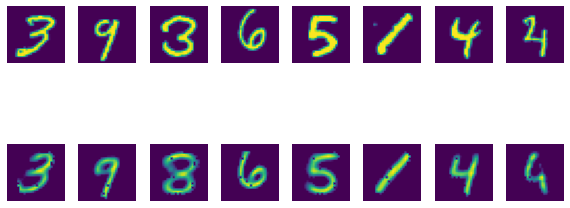

Epoch: 19/25  Loss: 0.0969


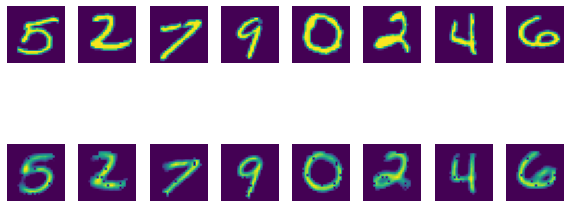

Epoch: 20/25  Loss: 0.0977


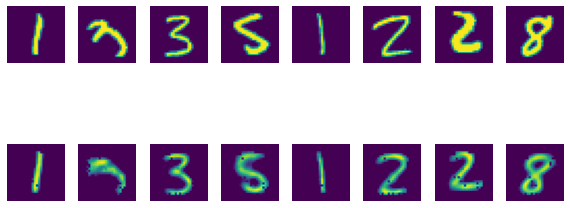

Epoch: 21/25  Loss: 0.0964


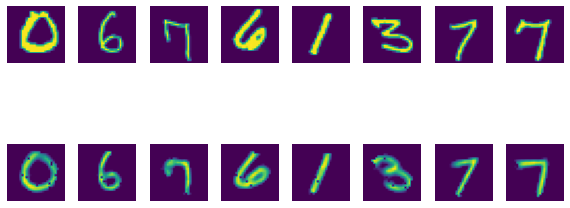

Epoch: 22/25  Loss: 0.1003


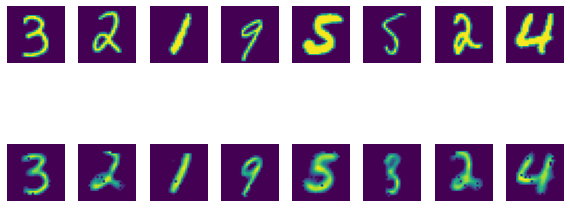

Epoch: 23/25  Loss: 0.0940


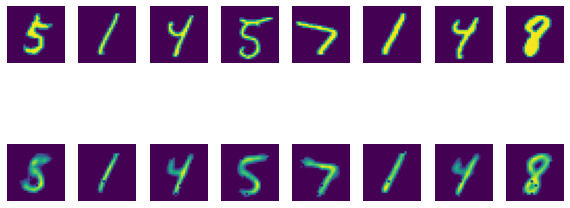

Epoch: 24/25  Loss: 0.0955


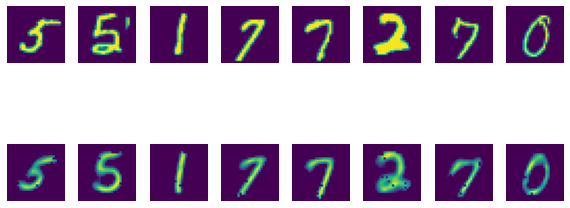

Epoch: 25/25  Loss: 0.1000


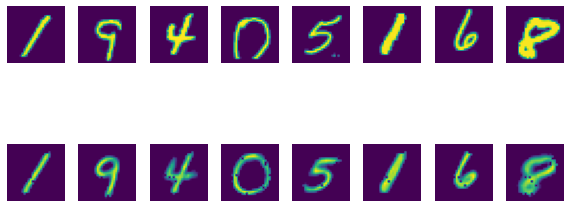

In [19]:
#Training the model
losses=[]

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        labels = labels.to(device)

        images = images.view(-1, 28*28)

        optimizer.zero_grad()

        output = model(images)

        loss = criterion(output, images) + beta*sparse_loss(rho, images)
        loss.backward()

        optimizer.step()

        loss = loss.detach().cpu().numpy()
        losses.append(loss.item())

    print('Epoch: {}/{} '.format(epoch+1, num_epochs),
              'Loss: {:.4f}'.format(loss))
    
    #Reshaping the data
    data = images.reshape(-1 , 28,28)
    output = output.reshape(-1, 28, 28)

    #To convert cuda tensor to numpy array
    data= data.detach().cpu().numpy()
    output = output.detach().cpu().numpy()

    #Plotting the data
    plt.figure(figsize = (10,20))

    for i in range(8):
        plt.subplot(16,8,i+1)
        plt.imshow(data[i])
        plt.axis('off')

        plt.subplot(16,8,i + 17)
        plt.imshow(output[i])
        plt.axis('off')

    plt.show()


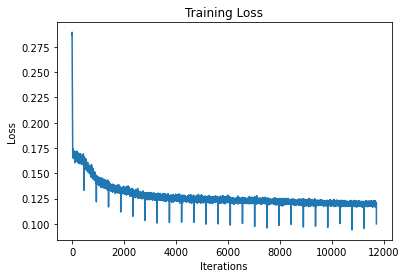

In [20]:
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(losses)
plt.show()

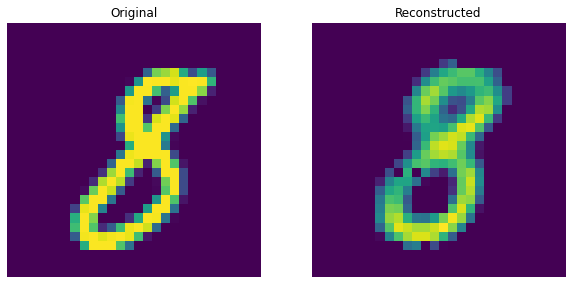

In [21]:
index= random.randint(0, len(test_dataset))

with torch.no_grad():
    data= test_dataset[index][0].view(-1, 28*28)
    data= data.to(device)
    output = model(data)
    
    data=data.detach().cpu().numpy()
    data = data.reshape(-1, 28, 28)

    output = output.detach().cpu().numpy()
    output = output.reshape(-1, 28, 28)

    plt.figure(figsize = (10,25))
    plt.subplot(1,2,1)
    plt.title('Original')
    plt.imshow(data[0])
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title('Reconstructed')
    plt.imshow(output[0])
    plt.axis('off')
    plt.show()